In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os

# Check the structure of the 'train' folder
train_dir = '/kaggle/input/catvsdog/test'
print("Train directory contents:", os.listdir(train_dir))

# Check the structure of the 'test' folder
test_dir = '/kaggle/input/catvsdog/train'
print("Test directory contents:", os.listdir(test_dir))


Train directory contents: ['dogs', 'cats']
Test directory contents: ['dogs', 'cats']


In [ ]:
import os

# Paths to train and test directories
train_dir = '/kaggle/input/catvsdog/train'
test_dir = '/kaggle/input/catvsdog/test'

def count_images_in_folder(folder_path):
    # Dictionary to store counts for each subfolder
    image_counts = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Count all files in the subfolder
            image_counts[subfolder] = len([
                f for f in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, f))
            ])
    return image_counts

# Count images in train and test directories
train_image_counts = count_images_in_folder(train_dir)
test_image_counts = count_images_in_folder(test_dir)

print("Train Image Counts:", train_image_counts)
print("Test Image Counts:", test_image_counts)


Train Image Counts: {'dogs': 10000, 'cats': 10000}
Test Image Counts: {'dogs': 2500, 'cats': 2500}


In [ ]:
import sys
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_from_csv(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Check if required columns exist
    required_columns = {"Epoch", "Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss"}
    if not required_columns.issubset(data.columns):
        print(f"CSV file must contain the columns: {required_columns}")
        return

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy', marker='o')
    plt.plot(data['Epoch'], data['Val Accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss', marker='o')
    plt.plot(data['Epoch'], data['Val Loss'], label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd


# Define the test harness
def run_test_harness():
    model = define_model()

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog/train/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # For testing, no augmentation is applied, only rescaling
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_it = test_datagen.flow_from_directory(
        '/kaggle/input/catvsdog/test/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Store accuracy and loss values
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Fit the model with correct steps_per_epoch and validation_steps
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=50,
    )

    # Extract accuracy and loss values for each epoch
    for epoch in range(50):  # Assuming 40 epochs
        train_acc.append(history.history['accuracy'][epoch])
        val_acc.append(history.history['val_accuracy'][epoch])
        train_loss.append(history.history['loss'][epoch])
        val_loss.append(history.history['val_loss'][epoch])

    # Save the values in a DataFrame or CSV
    data = {
        'Epoch': np.arange(1, 51),
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history.csv', index=False)  # Save to CSV in the Colab directory

    print(df)


In [ ]:
run_test_harness()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733466353.067656      92 service.cc:145] XLA service 0x7f21b8004ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733466353.067750      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733466353.067757      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.4922 - loss: 4.1562   

I0000 00:00:1733466362.903811      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 413ms/step - accuracy: 0.4951 - loss: 0.9173 - val_accuracy: 0.5006 - val_loss: 0.6931
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 311ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 309ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 311ms/step - accuracy: 0.4929 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 318ms/step - accuracy: 0.4916 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 312ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 310ms/step - accuracy: 0.4953 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 317ms/step - accuracy: 0.4922 - loss: 0.69

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd


# Define the test harness
def run_test_harness():
    model = define_model()

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog/train/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # For testing, no augmentation is applied, only rescaling
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_it = test_datagen.flow_from_directory(
        '/kaggle/input/catvsdog/test/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Store accuracy and loss values
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Fit the model with correct steps_per_epoch and validation_steps
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=50,
    )

    # Extract accuracy and loss values for each epoch
    for epoch in range(50):  # Assuming 40 epochs
        train_acc.append(history.history['accuracy'][epoch])
        val_acc.append(history.history['val_accuracy'][epoch])
        train_loss.append(history.history['loss'][epoch])
        val_loss.append(history.history['val_loss'][epoch])

    # Save the values in a DataFrame or CSV
    data = {
        'Epoch': np.arange(1, 51),
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history.csv', index=False)  # Save to CSV in the Colab directory

    print(df)


In [ ]:
run_test_harness()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 209s 320ms/step - accuracy: 0.5370 - loss: 0.7780 - val_accuracy: 0.6182 - val_loss: 0.6663
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 309ms/step - accuracy: 0.6099 - loss: 0.6530 - val_accuracy: 0.6848 - val_loss: 0.6045
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 309ms/step - accuracy: 0.6611 - loss: 0.6071 - val_accuracy: 0.7108 - val_loss: 0.5631
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 307ms/step - accuracy: 0.6974 - loss: 0.5763 - val_accuracy: 0.7354 - val_loss: 0.5218
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 306ms/step - accuracy: 0.7148 - loss: 0.5486 - val_accuracy: 0.7540 - val_loss: 0.4997
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 304ms/step - accuracy: 0.7408 - loss: 0.5206 - val_accuracy: 0.7560 - val_loss: 0.4935
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 305ms/step - accuracy: 0.7506 - loss: 0.5035 - val_accuracy: 0.7770 - val_loss

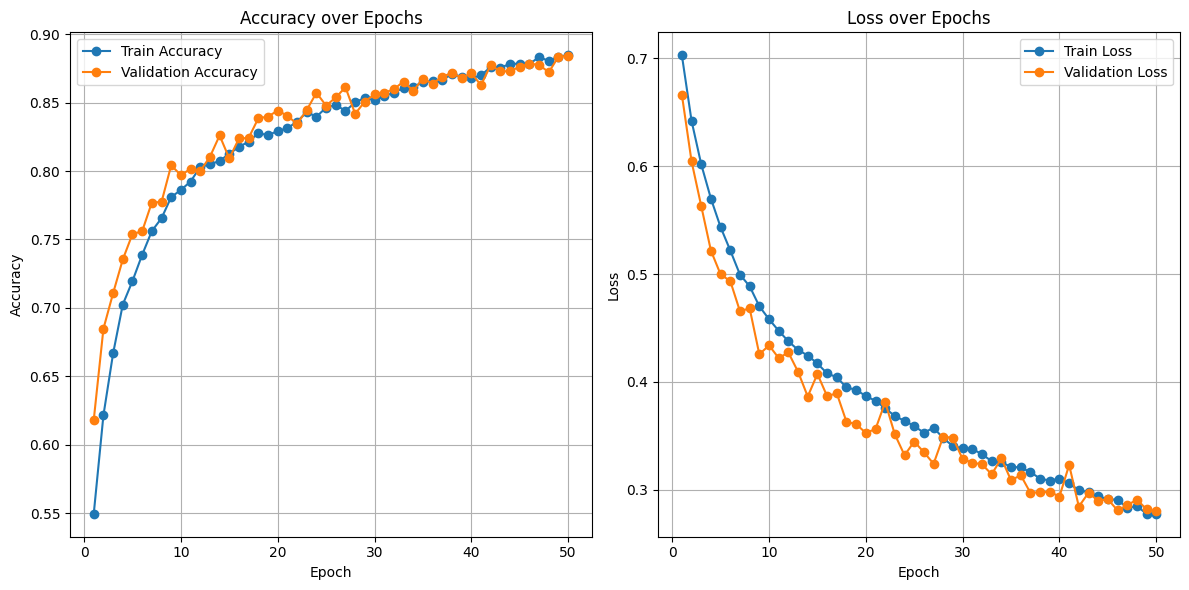

In [ ]:
plot_from_csv('training_history.csv')

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same', input_shape=(200, 200, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
import numpy as np
import pandas as pd


# Define the test harness
def run_test_harness():
    model = define_model()

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        '/kaggle/input/catvsdog/train/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # For testing, no augmentation is applied, only rescaling
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_it = test_datagen.flow_from_directory(
        '/kaggle/input/catvsdog/test/',
        batch_size=32,
        target_size=(200, 200),
        class_mode='binary'
    )

    # Store accuracy and loss values
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    # Fit the model with correct steps_per_epoch and validation_steps
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=80,
    )

    # Extract accuracy and loss values for each epoch
    for epoch in range(80):  # Assuming 40 epochs
        train_acc.append(history.history['accuracy'][epoch])
        val_acc.append(history.history['val_accuracy'][epoch])
        train_loss.append(history.history['loss'][epoch])
        val_loss.append(history.history['val_loss'][epoch])

    # Save the values in a DataFrame or CSV
    data = {
        'Epoch': np.arange(1, 81),
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    df = pd.DataFrame(data)
    df.to_csv('training_history.csv', index=False)  # Save to CSV in the Colab directory

    print(df)

In [ ]:
run_test_harness()

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 312ms/step - accuracy: 0.6124 - loss: 0.7725 - val_accuracy: 0.7128 - val_loss: 0.5560
Epoch 2/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 305ms/step - accuracy: 0.6901 - loss: 0.5752 - val_accuracy: 0.7586 - val_loss: 0.5043
Epoch 3/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 305ms/step - accuracy: 0.7282 - loss: 0.5313 - val_accuracy: 0.7862 - val_loss: 0.4545
Epoch 4/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 305ms/step - accuracy: 0.7502 - loss: 0.5073 - val_accuracy: 0.7878 - val_loss: 0.4492
Epoch 5/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 307ms/step - accuracy: 0.7694 - loss: 0.4803 - val_accuracy: 0.7848 - val_loss: 0.4485
Epoch 6/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 305ms/step - accuracy: 0.7806 - loss: 0.4556 - val_accuracy: 0.8156 - val_loss: 0.4116
Epoch 7/80
316/625 ━━━━━━━━━━━━━━━━━━━━ 1:29 288ms/step - accuracy: 0.7827 - loss: 0.4635